In [3]:
import pandas as pd
from nltk import RegexpTokenizer
from gensim.models import Word2Vec
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from flair.embeddings import TransformerWordEmbeddings
from flair.data import Sentence
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score,f1_score,recall_score,balanced_accuracy_score,confusion_matrix,ConfusionMatrixDisplay
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.sequence import pad_sequences
import numpy as np
tqdm.pandas()
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv("labeled_df.csv")
df.head()

,left_context,candidate_skill,right_context,concatenated,label
0,answer specific,business questions identifying,calling data,answer specific | business questions identifyi...,0
1,docker nginx,sql,nosql databases,docker nginx | sql | nosql databases,1
2,etl software informatica oracle pl,sql scripting,sql scripting unix scripting,etl software informatica oracle pl | sql scrip...,1
3,cv,standard chartered we re,international,cv | standard chartered we re | international,0
4,data science,coe leverage huge,volumes structured,data science | coe leverage huge | volumes str...,0


# word2vec word embedding

In [6]:
tokenized_sentences = []

# Iterate over each row in the DataFrame
for _, row in df.iterrows():
    # Tokenize each part of the sentence (left_context, candidate_skill, right_context)
    tokenized_sentence = []
    for col in ['left_context', 'candidate_skill', 'right_context']:
        sentence_tokens = word_tokenize(row[col])
        tokenized_sentence.extend(sentence_tokens)
    
    tokenized_sentences.append(tokenized_sentence)


In [7]:
w2v_model = Word2Vec(vector_size = 300,
                     window = 5,
                     min_count = 1,
                     workers = 20,
                     sg = 1,
                     negative = 5,
                     sample = 1e-5)
w2v_model.build_vocab(tokenized_sentences)
w2v_model.train(tokenized_sentences, 
                total_examples=w2v_model.corpus_count, 
                epochs=1001, 
                report_delay=1,
                compute_loss = True)

(4128605, 23137114)

In [8]:
def word2vec_vocab_check(text):
    tokenizer = RegexpTokenizer(r'\w+')
    tokens =  tokenizer.tokenize(text)
    try:
        w2v_model.wv[tokens]
        return True
    except:
        return False

#Function to retrieve word2vec vectors from spacy
def word2vec_retriever_sum(text):
    tokenizer = RegexpTokenizer(r'\w+')
    tokens =  tokenizer.tokenize(text)
    wordvectors = sum(w2v_model.wv[tokens])
    return wordvectors
    
def word2vec_retriever_average(text):
    tokenizer = RegexpTokenizer(r'\w+')
    tokens =  tokenizer.tokenize(text)
    wordvectors = w2v_model.wv[tokens]
    average = sum(wordvectors)/len(wordvectors)
    return average

In [9]:
#Removing out of vocabulary word2vec words
df['vocab_check_left'] = df['left_context'].progress_apply(word2vec_vocab_check)
df['vocab_check_middle'] = df['candidate_skill'].progress_apply(word2vec_vocab_check)
df['vocab_check_right'] = df['right_context'].progress_apply(word2vec_vocab_check)
df = df[(df.vocab_check_left==True) & (df.vocab_check_middle==True) & (df.vocab_check_right==True)]
df = df.drop(columns=['vocab_check_left', 'vocab_check_middle', 'vocab_check_right'])
len(df)

100%|███████████████████████████████████████████████████████████████████████████| 2976/2976 [00:00<00:00, 33327.95it/s]


2969

In [10]:
mode = word2vec_retriever_sum
#Retrieving the word2vec vectors
x_left = pd.DataFrame(df['left_context'].progress_apply(mode))
x_left = x_left['left_context'].progress_apply(pd.Series)

#Retrieving the word2vec vectors
x_right = pd.DataFrame(df['right_context'].progress_apply(mode))
x_right = x_right['right_context'].progress_apply(pd.Series)

#Retrieving the word2vec vectors
x_middle = pd.DataFrame(df['candidate_skill'].progress_apply(mode))
x_middle = x_middle['candidate_skill'].progress_apply(pd.Series)

x_mode = x_left
x_mode['sep'] = 5555
x_mode = x_mode.join(x_middle,lsuffix='_left', rsuffix='_middle')
x_mode['sep2'] = 5555
x_mode = x_mode.join(x_right,lsuffix='_middle', rsuffix='_right')

100%|████████████████████████████████████████████████████████████████████████████| 2969/2969 [00:00<00:00, 6460.13it/s]


In [11]:
mean = word2vec_retriever_average
#Retrieving the word2vec vectors
x_left = pd.DataFrame(df['left_context'].progress_apply(mean))
x_left = x_left['left_context'].progress_apply(pd.Series)

#Retrieving the word2vec vectors
x_right = pd.DataFrame(df['right_context'].progress_apply(mean))
x_right = x_right['right_context'].progress_apply(pd.Series)

#Retrieving the word2vec vectors
x_middle = pd.DataFrame(df['candidate_skill'].progress_apply(mean))
x_middle = x_middle['candidate_skill'].progress_apply(pd.Series)

x_mean = x_left
x_mean['sep'] = 5555
x_mean = x_mean.join(x_middle,lsuffix='_left', rsuffix='_middle')
x_mean['sep2'] = 5555
x_mean = x_mean.join(x_right,lsuffix='_middle', rsuffix='_right')

100%|████████████████████████████████████████████████████████████████████████████| 2969/2969 [00:00<00:00, 5587.10it/s]


# BERT

In [12]:
embedding = TransformerWordEmbeddings('bert-base-uncased')

In [13]:
def bert_embedder(text):

    string = Sentence(text)
    embedding.embed(string)

    # Creating a list which stores the indexes of the | symbols
    bar_indexes = []
    #Creating a list which stores the embedding_tensors
    embedding_tensors = []

    #Checking the sentence object for the | symbols and storing their indexes
    for x in range(1,len(string)+1):
        if '|' in str(string.get_token(x)):
            bar_indexes.append(x)

    #Collecting the embeddings for every index between the indexes in bar_indexes
    word_embedding_indexes = range(bar_indexes[0]+1,bar_indexes[1])
    for x in word_embedding_indexes:
        embedding_tensors.append(pd.Series(string[x].embedding))
        embedding_tensors.append(5)

    #Removing last 5 from list
    embedding_tensors.pop()

    #Turning the elements from embedding_tensors into dataframe rows
    row = pd.DataFrame()
    for x in range(0,len(embedding_tensors)):
        row = row.append(pd.DataFrame(pd.Series(embedding_tensors[x])))

    row = row.transpose().reset_index(drop=True)
    
    #Changing the column names in order to make pd.concat work later
    row.columns = [x for x in range(0,len(row.columns))]
    return row

In [14]:
df['embeddings'] = df['concatenated'].progress_apply(bert_embedder)

100%|████████████████████████████████████████████████████████████████████████████| 2969/2969 [1:23:32<00:00,  1.69s/it]


In [15]:
x_bert = pd.concat(df['embeddings'].tolist()).reset_index(drop=True)
x_bert = x_bert.fillna(0)
x_bert.head()

,0,1,2,3,4,5,6,7,8,9,...,3065,3066,3067,3068,3069,3070,3071,3072,3073,3074
0,-0.295705,-0.058122,0.444323,-0.142574,0.858735,-0.380390,0.078294,-0.094128,-0.577954,0.106808,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.123347,-0.209599,-0.116502,-0.085392,0.816365,0.402948,-0.011889,0.858283,-0.412918,-0.144275,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.252260,-0.141483,0.269064,-0.037710,-0.477046,-0.302860,-0.482875,0.629631,0.234631,0.233005,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1.019749,0.152619,-0.578367,0.215986,0.607000,-0.402432,-0.073561,0.621917,-0.092208,0.361589,...,-0.005939,0.074809,-0.007369,-0.369125,0.514113,0.319215,0.494222,0.412437,-0.161125,-0.529087
4,-0.003204,0.102263,0.090247,0.101615,0.485402,-0.125427,-0.250190,-0.032104,0.491692,-0.989001,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Classification

In [16]:
def evaluation_metrics(y_test, pred):
    p = precision_score(y_test, pred)
    r = recall_score(y_test, pred)
    f = f1_score(y_test, pred)
    a = balanced_accuracy_score(y_test, pred)
    c = confusion_matrix(y_test, pred)

    label = ['0','1']
    cm_disp = ConfusionMatrixDisplay(confusion_matrix=c, display_labels=label)
    
    print("Balanced Accuracy: ",round(a*100,2))
    print("Precision: ",round(p*100,2))
    print("Recall: ",round(r*100,2))
    print("F1-score: ",round(f*100,2))
    print("Confusion matrix")
    cm_disp.plot()
    plt.title('Confusion Matrix')
    plt.show()

In [17]:
column_names_bert = x_bert.columns.tolist()
column_names_mode = x_mode.columns.tolist()
column_names_mean = x_mean.columns.tolist()

X_bert = x_bert[column_names_bert].values
X_mode = x_mode[column_names_mode].values
X_mean = x_mean[column_names_mean].values

y = df['label'].values

x_bert_train,x_bert_test,y_bert_train,y_bert_test=train_test_split(X_bert, y, test_size=0.2,random_state=456)
x_mode_train,x_mode_test,y_mode_train,y_mode_test=train_test_split(X_mode, y, test_size=0.2,random_state=456)
x_mean_train,x_mean_test,y_mean_train,y_mean_test=train_test_split(X_mean, y, test_size=0.2,random_state=456)

Balanced Accuracy:  82.4
Precision:  75.0
Recall:  78.0
F1-score:  76.47
Confusion matrix


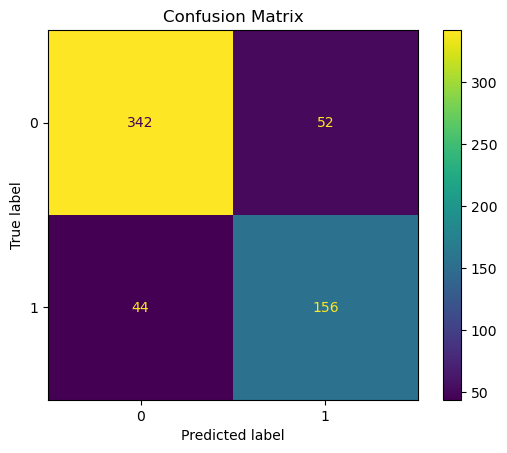

In [18]:
#word2vec+mode
lr_mode = LogisticRegression(solver='lbfgs')
lr_mode.fit(x_mode_train,y_mode_train)
mode_pred = lr_mode.predict(x_mode_test)
evaluation_metrics(y_mode_test, mode_pred)

Balanced Accuracy:  73.98
Precision:  64.11
Recall:  67.0
F1-score:  65.53
Confusion matrix


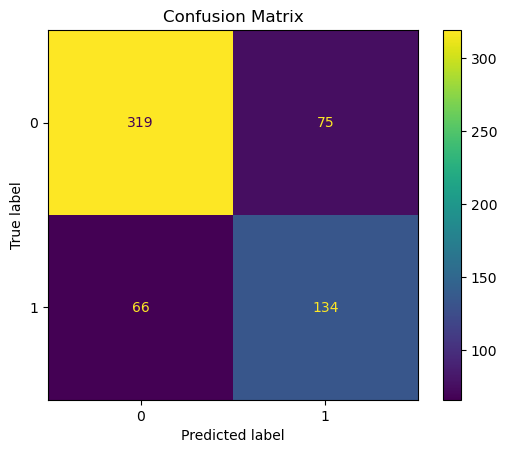

In [19]:
#word2vec+mean
lr_mean = LogisticRegression(solver='lbfgs')
lr_mean.fit(x_mean_train,y_mean_train)
mean_pred = lr_mean.predict(x_mean_test)
evaluation_metrics(y_mean_test, mean_pred)

Balanced Accuracy:  85.17
Precision:  80.1
Recall:  80.5
F1-score:  80.3
Confusion matrix


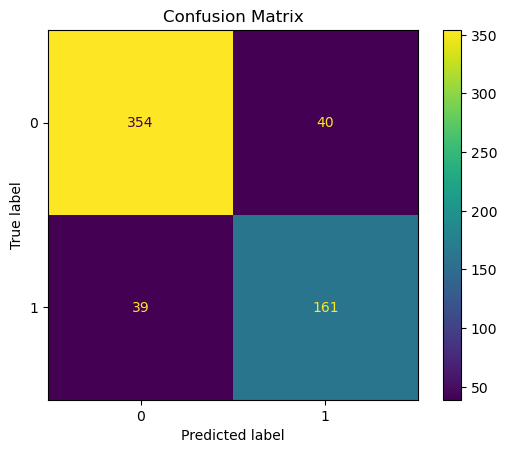

In [20]:
#bert
lr_bert = LogisticRegression(solver='lbfgs')
lr_bert.fit(x_bert_train,y_bert_train)
bert_pred = lr_bert.predict(x_bert_test)
evaluation_metrics(y_bert_test, bert_pred)

In [27]:
n_splits = 5
kfold = StratifiedKFold(n_splits=n_splits, random_state=42, shuffle=True)

param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    
}
logreg = LogisticRegression(random_state = 42, solver='lbfgs')

logreg_cv = GridSearchCV(logreg, param_grid = param_grid,
                         cv = kfold, scoring = 'balanced_accuracy',
                         n_jobs = -1, verbose = 1)
logreg_cv.fit(x_bert_train,y_bert_train)
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("Balanced Accuracy :",logreg_cv.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2'}
Balanced Accuracy : 0.8858713310796791


Balanced Accuracy:  86.69
Precision:  83.59
Recall:  81.5
F1-score:  82.53
Confusion matrix


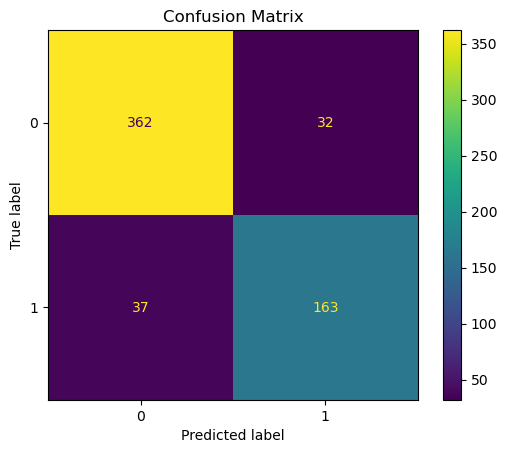

In [29]:
#bert
best_lr_bert = LogisticRegression(C=0.1, solver='lbfgs', penalty='l2')
best_lr_bert.fit(x_bert_train,y_bert_train)
best_bert_pred = best_lr_bert.predict(x_bert_test)
evaluation_metrics(y_bert_test, best_bert_pred)

# LSTM

In [30]:
#word2vec+mode
# Set the embedding dimension 
embedding_dim = 128 

# Pad sequences to a consistent length
max_sequence_length = 500  
x_mode_padded = pad_sequences(x_mode.values.tolist(), maxlen=max_sequence_length)  # Convert DataFrame to a list of lists

# Calculate the vocabulary size (unique words)
vocabulary_size = len(set(word for sublist in x_mode.values.tolist() for word in sublist))

# Ensure all indices are within the vocabulary range
x_mode_padded = np.where(x_mode_padded < vocabulary_size, x_mode_padded, 0)

# Ensure all indices are non-negative
x_mode_padded = np.where(x_mode_padded >= 0, x_mode_padded, 0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_mode_padded, y, test_size=0.2, random_state=456)

# Build the model with an embedding layer
model = Sequential()
model.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=max_sequence_length))  # Add an embedding layer
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=16)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

Epoch 1/5
149/149 [==============================] - 502s 3s/step - loss: 0.6638 - accuracy: 0.6354 - val_loss: 0.6377 - val_accuracy: 0.6633
Epoch 2/5
149/149 [==============================] - 480s 3s/step - loss: 0.6580 - accuracy: 0.6362 - val_loss: 0.6411 - val_accuracy: 0.6633
Epoch 3/5
149/149 [==============================] - 469s 3s/step - loss: 0.6589 - accuracy: 0.6362 - val_loss: 0.6423 - val_accuracy: 0.6633
Epoch 4/5
149/149 [==============================] - 471s 3s/step - loss: 0.6598 - accuracy: 0.6362 - val_loss: 0.6426 - val_accuracy: 0.6633
Epoch 5/5
19/19 [==============================] - 5s 236ms/step - loss: 0.6392 - accuracy: 0.6633
Test Accuracy: 0.6632996797561646


<Figure size 1200x400 with 0 Axes>

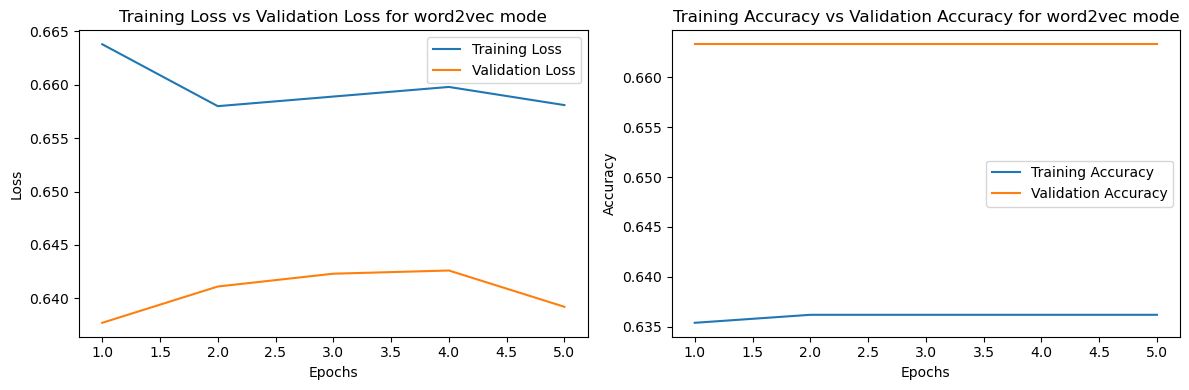

In [38]:
epochs = [1,2,3,4,5]
loss = [0.6638,0.6580,0.6589,0.6598,0.6581]
acc = [0.6354,0.6362,0.6362,0.6362,0.6362]
v_loss = [0.6377,0.6411,0.6423,0.6426,0.6392]
v_acc = [0.6633,0.6633,0.6633,0.6633,0.6633]
plt.figure(figsize=(12, 4))

plt.figure(figsize=(12, 4))

# Plot loss against validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, v_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss vs Validation Loss for word2vec mode')

# Plot accuracy against validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, v_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Accuracy vs Validation Accuracy for word2vec mode')

plt.tight_layout()
plt.show()

In [51]:
#word2vec+mode
# Set the embedding dimension 
embedding_dim = 128 

# Pad sequences to a consistent length
max_sequence_length = 500  
x_mean_padded = pad_sequences(x_mean.values.tolist(), maxlen=max_sequence_length)  # Convert DataFrame to a list of lists

# Calculate the vocabulary size (unique words)
vocabulary_size = len(set(word for sublist in x_mean.values.tolist() for word in sublist))

# Ensure all indices are within the vocabulary range
x_mean_padded = np.where(x_mean_padded < vocabulary_size, x_mean_padded, 0)

# Ensure all indices are non-negative
x_mean_padded = np.where(x_mean_padded >= 0, x_mean_padded, 0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_mean_padded, y, test_size=0.2, random_state=456)

# Build the model with an embedding layer
model = Sequential()
model.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=max_sequence_length))  # Add an embedding layer
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=16)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

Epoch 1/5
149/149 [==============================] - 422s 3s/step - loss: 0.6647 - accuracy: 0.6345 - val_loss: 0.6419 - val_accuracy: 0.6633
Epoch 2/5
149/149 [==============================] - 435s 3s/step - loss: 0.6584 - accuracy: 0.6362 - val_loss: 0.6415 - val_accuracy: 0.6633
Epoch 3/5
149/149 [==============================] - 575s 4s/step - loss: 0.6597 - accuracy: 0.6362 - val_loss: 0.6496 - val_accuracy: 0.6633
Epoch 4/5
149/149 [==============================] - 577s 4s/step - loss: 0.6589 - accuracy: 0.6362 - val_loss: 0.6481 - val_accuracy: 0.6633
Epoch 5/5
19/19 [==============================] - 5s 269ms/step - loss: 0.6398 - accuracy: 0.6633
Test Accuracy: 0.6632996797561646


<Figure size 1200x400 with 0 Axes>

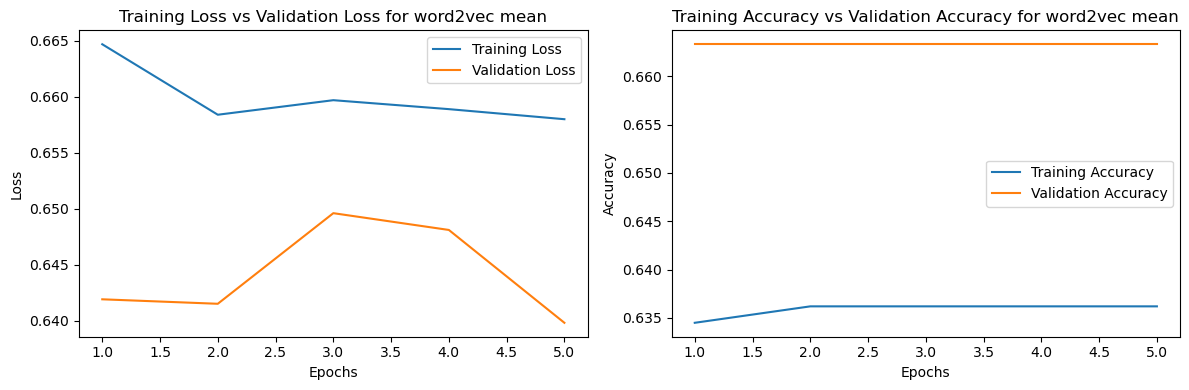

In [40]:
epochs = [1,2,3,4,5]
loss = [0.6647, 0.6584,0.6597,0.6589,0.6580]
acc = [0.6345,0.6362,0.6362,0.6362,0.6362]
v_loss = [0.6419,0.6415,0.6496,0.6481,0.6398]
v_acc = [0.6633,0.6633,0.6633,0.6633,0.6633]
plt.figure(figsize=(12, 4))

plt.figure(figsize=(12, 4))

# Plot loss against validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, v_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss vs Validation Loss for word2vec mean')

# Plot accuracy against validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, v_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Accuracy vs Validation Accuracy for word2vec mean')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.sequence import pad_sequences
import numpy as np

# Assuming you have x_bert1 as the BERT embeddings and y as your labels
# Set the embedding dimension based on the number of columns in your BERT embeddings
embedding_dim = 100  # Adjust as needed

# Preprocess the data: Pad sequences to a consistent length
max_sequence_length = 100  # Choose an appropriate sequence length
x_bert_padded = pad_sequences(x_bert.values.tolist(), maxlen=max_sequence_length)  # Convert DataFrame to a list of lists

# Calculate the vocabulary size (unique words)
vocabulary_size = len(set(word for sublist in x_bert.values.tolist() for word in sublist))

# Ensure all indices are within the vocabulary range
x_bert_padded = np.where(x_bert_padded < vocabulary_size, x_bert_padded, 0)

# Ensure all indices are non-negative
x_bert_padded = np.where(x_bert_padded >= 0, x_bert_padded, 0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_bert_padded, y, test_size=0.2, random_state=42)

# Build the model with an embedding layer
model = Sequential()
model.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=max_sequence_length))  # Add an embedding layer
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification, adjust as needed

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=16)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)


Epoch 1/5
149/149 [==============================] - 2703s 18s/step - loss: 0.6543 - accuracy: 0.6438 - val_loss: 0.6593 - val_accuracy: 0.6330
Epoch 2/5
 95/149 [==================>...........] - ETA: 15:06 - loss: 0.6662 - accuracy: 0.6276

<Figure size 1200x400 with 0 Axes>

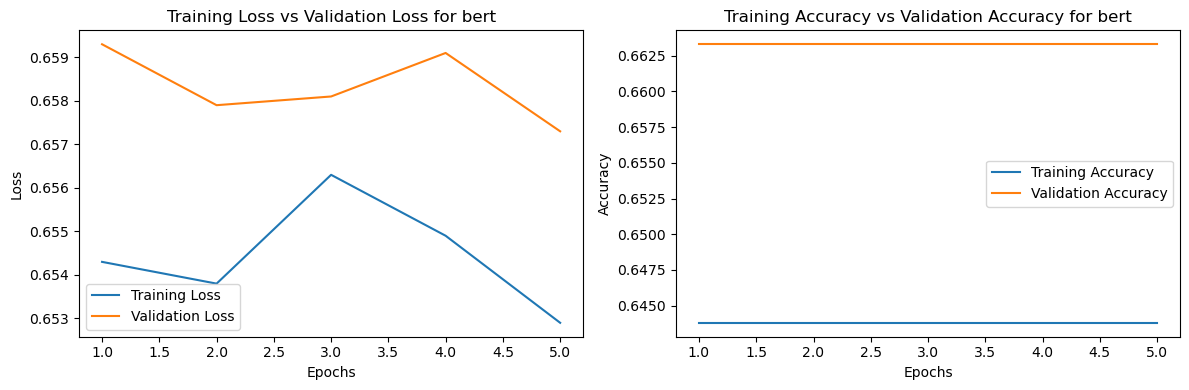

In [41]:
epochs = [1,2,3,4,5]
loss = [0.6543,0.6538,0.6563,0.6549,0.6529]
acc = [0.6438,0.6438,0.6438,0.6438,0.6438]
v_loss = [0.6593,0.6579,0.6581,0.6591,0.6573]
v_acc = [0.6633,0.6633,0.6633,0.6633,0.6633]
plt.figure(figsize=(12, 4))

plt.figure(figsize=(12, 4))

# Plot loss against validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, v_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss vs Validation Loss for bert')

# Plot accuracy against validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, v_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Accuracy vs Validation Accuracy for bert')

plt.tight_layout()
plt.show()